In [1]:
import numpy as np
import pandas as pd
from pcse.db import NASAPowerWeatherDataProvider
from pcse.util import reference_ET
import datetime
from matplotlib import pyplot as plt
from tqdm import tqdm as tqdm

sys.path.append("../src/")
from sarra_py import *


In [2]:
# https://towardsdatascience.com/read-era5-directly-into-memory-with-python-511a2740bba0

In [3]:
grid_width = 1
grid_height = 1
duration = 365

In [4]:
sys.path.append("../data/")
from params import paramVariete_USA_iowa_V42

In [5]:
paramVariete

NameError: name 'paramVariete' is not defined

In [6]:
from logging import exception


paramVariete = {

                # paramètres depuis Ag3 USA Hars v42_12_ p4 irr
                # récupérés depuis HV42 parameters
                # variete mais iowa USA V42
                
                "SDJLevee":90., # OK
                "SDJBVP":320., # OK
                "SDJRPR":500, # OK
                "SDJMatu1":560., # OK
                "SDJMatu2":200., # OK
                
                "KRdtPotA": 0.8,  # OK
                "KRdtPotB": 200., # OK

                "PPExp" : 0., # OK
                "SeuilPP" : 13.6, # OK
                "PPsens" : 5., # OK
                "PPCrit": 11., # OK

                "TBase":8., # OK
                "TOpt1":26., # OK
                "TOpt2":34., # OK
                "TLim":44., # OK

                "pcReallocFeuille":0.7, # OK # partFeuilleTige
                'txConversion':5.8, # OK
                'txAssimBVP':1., # OK
                'txAssimMatu1':0.9, # OK
                'txAssimMatu2':0.1,  # OK

                "kRespMaint":0.01, # OK
                "aeroTotBase":0.6, # OK
                "aeroTotPente":5E-5, # OK
                "feuilAeroBase":0.55, # OK
                "feuilAeroPente":-5E-5, # OK

                "txRealloc":0.4, # OK #realloc
                "tempMaint":25., # OK
                "KRdtBiom":0., # OK
                
                "kcMax":1.25, # OK
                "PFactor":0.45, # OK
                "seuilCstrMortality":3., # OK

                'kdf': 0.4,  # OK
                "poidsSecGrain":0.38, # OK
                "txResGrain":0.55, # OK

                "VRacLevee":30.0, # OK
                "VRacBVP":15.0, # OK
                "VRacPSP":15.0, # OK
                "VRacRPR":15.0, # OK
                "VRacMatu1":12.0, # OK
                "VRacMatu2":12.0, # OK

                "slaMin":0.0016, # OK
                "slaMax":0.005, # OK
                "slaPente":0.4, # OK

                "phaseDevVeg":0, # OK
                "senCO2":10., # OK
                
                "densOpti":85000., # OK
                "densiteA":0.7, # OK
                "densiteP":4.5, # OK

                "NIYo":1.,
                "NIp":0.,
                "LGauss":1.,
                "AGauss":1.,

                }

if paramVariete["feuilAeroBase"] == 0.1 :
    raise exception()



paramITK = {
            "DateSemis":datetime.date(2012,4,28), # OK
            "profRacIni":0.,# OK
            "densite":86500., # OK
            "mulch":100.,  # OK
            "seuilEauSemis":0., # OK
            "nbjTestSemis":0, # OK
            "irrigAuto":False, # OK
            "irrigAutoTarget":0., # OK
            "maxIrrig":0., # OK
            "precision":0., # OK
            "biomIniMc":0., # OK
            "humSatMc":0., # OK
            "surfMc":0., # OK
            "coefMc":0., # OK

            "KNUp":0., # OK
            "KNLit":0., # OK
            "KT":0., # OK
            "KI":0., # OK
            
            # non utilisés dans le modèle python
            "DisMc":000000, # OK
            "TxRecolte":0., # OK
            "TxaTerre":0., # OK
            "NbUBT":10., # OK
            
            # non présents dans sarra-h
            "dateFin":300.,
            "NI":np.nan, 

            }

paramTypeSol = {
                "stockIniSurf":30., # OK
                "stockIniProf":170., # OK
                "epaisseurSurf": 200., # OK
                "epaisseurProf" : 1300., # OK

                # params type sol
                "seuilRuiss":20., # OK
                "pourcRuiss":30/100., # OK
                "ru":132., # OK

                # non utilisés mais présents dans sarra-h
                "HumCR":0.32, # OK
                "HumPF":0.18, # OK
                'HumFC':0.32, # OK
                "HumSat":0.48, # OK
                "Pevap":0.2, # OK
                "PercolationMax":5., # OK

                }

if ~np.isnan(paramITK["NI"]):
    print("NI NON NULL") 
    paramVariete["txConversion"] = paramVariete["NIYo"] + paramVariete["NIp"] * (1-np.exp(-paramVariete["NIp"] * paramITK["NI"])) - (np.exp(-0.5*((paramITK["NI"] - paramVariete["LGauss"])/paramVariete["AGauss"])* (paramITK["NI"]- paramVariete["LGauss"])/paramVariete["AGauss"]))/(paramVariete["AGauss"]*2.506628274631)

In [7]:
import json

with open('../data/params/paramVariete_USA_iowa_V42.json', 'w') as f:
    json.dump(paramVariete, f)

In [5]:
#elevation = 329
date_start = datetime.date(2012,4,1)

# loading weather data and rain data exported from SARRA-H
df_weather = pd.read_csv("../data/Meteorologie_US0001.txt", sep="\t", decimal=",", skiprows=1)
df_rain = pd.read_csv("../data/Pluviometrie_US0001.txt", sep="\t", decimal=",", skiprows=1)
df_weather = df_weather.merge(df_rain, right_on=["Jour", "CodeStation"], left_on=["Jour", "CodeStation"])
df_weather["Jour"] = df_weather.apply(lambda x: datetime.datetime.strptime(x["Jour"], "%d/%m/%Y").date(), axis=1)
df_weather = df_weather[(df_weather["Jour"]>=date_start) & (df_weather["Jour"]<=date_start+datetime.timedelta(days=duration-1))].reset_index(drop=True)
df_weather = df_weather.rename(columns={"Pluie":"RAIN"})
df_weather["TMoy"] = ((df_weather["TMin"]+df_weather["TMax"])/2) # + 273.15
df_weather = df_weather.rename(columns={"TMoy":"TEMP", "Pluie":"RAIN", 'Rg':'IRRAD'})

df_ET0 = pd.read_csv("../data/ET0_US0001.txt", sep="\t", decimal=",", skiprows=1)
df_ET0["Jour"] = df_ET0.apply(lambda x: datetime.datetime.strptime(x["Jour"], "%d/%m/%Y").date(), axis=1)
df_ET0 = df_ET0[(df_ET0["Jour"]>=date_start) & (df_ET0["Jour"]<=date_start+datetime.timedelta(days=duration-1))].reset_index(drop=True)

df_weather = df_weather.merge(df_ET0[["Jour","Eto"]], left_on="Jour", right_on="Jour", how="outer")

df_weather["ET0"] = df_weather["Eto"]

df_irrig = pd.read_csv("../data/Irrigation_AG3US20124.txt", sep="\t", decimal=",", skiprows=1)
df_irrig["Jour"] = df_irrig.apply(lambda x: datetime.datetime.strptime(x["Jour"], "%d/%m/%Y").date(), axis=1)
df_weather = df_weather.merge(df_irrig[["Jour","Irrigation"]], left_on="Jour", right_on="Jour", how="outer")
df_weather.loc[np.isnan(df_weather["Irrigation"]), "Irrigation"] = 0

df_weather

,CodeStation,Jour,TMax,TMin,TEMP,HMax,HMin,HMoy,Vt,Ins,IRRAD,ETP,RAIN,Eto,ET0,Irrigation
0,US0001,2012-04-01,28.6,8.0,18.30,NaN,NaN,79.2,2.8,NaN,20.0,NaN,0.0,3.179907,3.179907,0.0
1,US0001,2012-04-02,29.4,11.4,20.40,NaN,NaN,73.8,4.3,NaN,19.0,NaN,0.0,3.950088,3.950088,30.0
2,US0001,2012-04-03,19.3,11.8,15.55,NaN,NaN,73.0,6.0,NaN,18.0,NaN,0.0,3.642551,3.642551,0.0
3,US0001,2012-04-04,19.6,11.6,15.60,NaN,NaN,46.7,4.4,NaN,16.0,NaN,0.0,4.539865,4.539865,0.0
4,US0001,2012-04-05,17.3,5.7,11.50,NaN,NaN,37.8,3.6,NaN,21.6,NaN,0.0,4.661987,4.661987,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,US0001,2013-03-27,6.9,-3.9,1.50,NaN,NaN,81.4,1.4,NaN,21.1,NaN,0.0,1.560502,1.560502,0.0
361,US0001,2013-03-28,11.7,-2.2,4.75,NaN,NaN,83.4,2.0,NaN,19.6,NaN,0.0,1.650961,1.650961,0.0
362,US0001,2013-03-29,14.7,-0.9,6.90,NaN,NaN,79.9,2.7,NaN,20.9,NaN,0.0,2.065429,2.065429,0.0
363,US0001,2013-03-30,14.1,4.1,9.10,NaN,NaN,90.5,2.2,NaN,7.0,NaN,1.8,0.971781,0.971781,0.0


ordre des modules depuis SarrahV42.docx

In [6]:
def EvalPar(data):
    #depuis meteo.par
    kpar = 0.5
    data["par"] = kpar * data["rg"]
    return data

# Run

In [7]:
data = {}

data = InitPlotMc(data, grid_width, grid_height, paramITK, paramTypeSol, duration) # **** bileau *** # trad OK
data = InitiationCulture(data, grid_width, grid_height, duration, paramVariete)
data = InitSup(data, grid_width, grid_height, duration, df_weather, paramTypeSol, paramITK)
data = EvalPar(data)

for j in range(duration):
    # on reporte en commentaire les fichiers source dans lesquelles se trouvent
    # les procédures concernées. no note ***entre étoiles*** les procédures
    # retenues pour cette traduction python

    
    
    print("\n cycle",j)

    if date_start + datetime.timedelta(days=j) >= paramITK["DateSemis"]:

        data = EvalPhenoSarrahV3(j, data, paramITK, paramVariete) # ***phenologie*** et exmodules ### trad OK
        data = EvalDegresJourSarrahV3(j, data, paramVariete) # ***phenologie*** et exmodules ### trad OK

    print(date_start + datetime.timedelta(days=j))
    #bilan hydrique
    data = EvalIrrigPhase(j, data, paramITK) # ***bileau***, exmodules 2 ### trad OK
    data = PluieIrrig(j, data) # ***bileau***, exmodules 2 ###trad OK
    data = RempliMc(j, data, paramITK) # ***bileau***, exmodules 2 ### trad OK
    data = EvalRunOff(j, data, paramTypeSol) # ***bileau***, exmodules 1 & 2 ###trad OK
    data = EvolRurCstr2(j, data, paramITK) # ***bileau*** ##trad OK
    data = rempliRes(j, data) # bhytypeFAO, ***bileau***; exmodules 1 & 2, risocas ###trad OK
    data = EvalFESW(j, data) # bhytypeFAO, ***bileau***; exmodules 1 & 2 ###trad O
    data = EvalKceMc(j, data, paramITK) # ***bileau***, exmodules 2 ###trad OK
    data = DemandeSol(j, data) # ***bileau***, exmodules 1 & 2 ### trad OK
    data = EvapMc(j, data, paramITK) # ***bileau***, exmodules 2 ### trad OK
    data = EvapRuSurf(j, data) # ***bileau***, exmodules 1 & 2 ###trad OK
    data = EvalFTSW(j, data) # ***bileau***, exmodules 1 & 2, risocas, riz ###trad OK
    data = EvolKcpKcIni(j, data, paramVariete) # biomasse, exmodules 1 & 2 # comparaison  code nécessaire pour choix ###trad OK
    data = DemandePlante(j, data) # bhytypeFAO, ***bileau***; exmodules 1 & 2 ###trad OK
    data = EvalKcTot(j, data) # ***bileau***, exmodules 1 & 2 ## trad O
    data = CstrPFactor(j, data, paramVariete) # bhytypeFAO, ***bileau***; exmodules 1 & 2, risocas #trad OK
    data = EvalTranspi(j, data) # bhytypeFAO, ***bileau***; exmodules 1 & 2 # trad OK
    data = ConsoResSep(j, data) # ***bileau***; exmodules 1 & 2 # trad O
    # phenologie
    data = EvalVitesseRacSarraV3(j, data, paramVariete) # ***phenologie*** , exmodules 1 & 2 # trad OK
    
    # bilan carbone
    data = EvalLtr(j, data, paramVariete) #biomasse, exmodules 1 & 2 # comparaison code nécessaire pour choix #trad OK
    data = EvalConversion(j, data, paramVariete) # mimlbilancarbone copie, ecopalm2_2, exmodules 1 & 2, ***milbilancarbone***, risocas, riz # trad OK
    data = BiomDensOptSarV42(j, data, paramITK, paramVariete) # ***bilancarbonsarra*** # trad OK
    data = EvalAssimSarrahV42(j, data, paramITK, paramVariete) # ***bilancarbonsarra*** # trad OK
    data = EvalRespMaintSarrahV3(j, data, paramVariete) # ***bilancarbonsarra***, exmodules 1 & 2 ### trad OK
    data = EvolBiomTotSarrahV4(j, data, paramVariete, paramITK) # ***bilancarbonsarra*** ### trad OK, vérifier questiond e la densité
    data = EvalRdtPotRespSarV42(j, data, paramVariete) # ***bilancarbonsarra*** ###trad OK
    data = EvolBiomAeroSarrahV3(j, data, paramVariete) # ***bilancarbonsarra***, exmodules 1 & 2 ###trad OK
    data = EvalReallocationSarrahV3(j, data, paramVariete) # ***bilancarbonsarra***, exmodules 1 & 2 ###trad OK
    data = EvalBiomasseRacinaire(j, data) # copie milbilancarbone, exmodules 1 & 2, ***milbilancarbone*** ### trad OK
    data = EvalFeuilleTigeSarrahV4(j, data, paramVariete) # ***bilancarbonesarra*** ### trad OK
    data = EvalBiomasseVegetati(j, data) # copie milbilancarbon, exmodules 1 & 2, ***milbilancarbone*** ###trad OK
    data = EvalSlaSarrahV3(j, data, paramVariete) # ***bilancarbonesarrah***, exmodules 1 & 2  ### trad OK
    data = EvolLAIPhases(j, data) # exmodules 1 & 2, ***milbilancarbone*** ###trad OK
    data = EvolDayRdtSarraV3(j, data) # ***bilancarbonesarra***, exmodules 1 & 2 ### trad OK
    #phenologie
    data = PhotoperSarrahV3(j, data, paramVariete) # exmodules 1 et 2, ***phenologie*** ###trad OK
    
    # bilan carbone
    data = MortaliteSarraV3(j, data, paramITK, paramVariete) # ***bilancarbonsarra***, exmodules 1 & 2 ### trad OK
    data = BiomDensiteSarraV42(j, data, paramITK, paramVariete)# ***bilancarbonsarra*** ### trad OK
    data = BiomMcUBTSV3(j, data, paramITK) # ***bilancarbonsarra***, exmodules 2
    data = MAJBiomMcSV3(data) # ***bilancarbonsarra***, exmodules 2



        



     


 cycle 0
2012-04-01
stRur 1 [[0.]]
stRur 2 [[0.]]
hum 1 [[170.]]
hum 2 [[170.]]
hum 5 [[170.]]
stRur 3 [[0.]]
stRur 4 [[0.]]
stRuSurf 3 [[0.]]
stRur 5 [[0.]]
stRuSurf 4 [[0.]]
stRur 6 [[0.]]
lai [[0.]]
exp(-lai x kdf) [[1.]]
ltr [[1.]]
NI NULL
lai 1 [[0.]]
assimPot [[0.]]
assim 1 [[0.]]
biomasseTotale 2 [[0.]]
biomassetotale calc
test biomasseTotale [[False]]
biomasseTotale 3 [[0.]]
biomasseTotale 5 [[0.]]
rdtpot calc
drdtpot calc
biomasseaerienne calc
biomasseTotale 6 [[0.]]
biomasseAerienne 1 [[0.]]
biomasseTotale 7 [[0.]]
condition 2 [[False]]
condition biomasseFeuille 2 [[False]]
biomasseFeuille 2 [[0.]]
biomasseFeuille 3 [[0.]]
biomasseAerienne 2 [[0.]]
sla 1 [[0.]]
sla 2 [[0.]]
sla 3 [[0.]]
lai 2 [[0.]]
rdt calc
rdt avt [[0.]]
rdt apres [[0.]]
rdtpot avt [[0.]]
rdtpot après [[0.]]
biomasseRacinaire fin [[0.]]
biomasseFeuille apres [[0.]]
biomasseAerienne avt [[0.]]
biomasseAerienne apres [[0.]]
biomasseTotale avt [[0.]]
biomasseTotale apres [[0.]]
biomasseTotale 8 [[0.]]
lai 4 [

/mnt/d/Mes Donnees/SARRA-Py/notebooks/../src/sarra_py/bilan_hydro.py:171: RuntimeWarning: invalid value encountered in divide
  (data["stockIrr"][:,:,j]/data["ruIrr"][:,:,j] < paramITK["irrigAutoTarget"])
/mnt/d/Mes Donnees/SARRA-Py/notebooks/../src/sarra_py/bilan_hydro.py:522: RuntimeWarning: invalid value encountered in divide
  data["stRur"][:,:,j]/data["stRurMax"][:,:,j],
/mnt/d/Mes Donnees/SARRA-Py/notebooks/../src/sarra_py/bilan_hydro.py:856: RuntimeWarning: invalid value encountered in divide
  (paramITK["humSatMc"] * data["biomMc"][:,:,j] * 0.001) / data["stockMc"][:,:,j],
/mnt/d/Mes Donnees/SARRA-Py/notebooks/../src/sarra_py/bilan_hydro.py:908: RuntimeWarning: invalid value encountered in divide
  data["stRur"][:,:,j] / data["stRurMax"][:,:,j],
/mnt/d/Mes Donnees/SARRA-Py/notebooks/../src/sarra_py/bilan_hydro.py:1038: RuntimeWarning: invalid value encountered in divide
  np.maximum(data["stRuSurf"][:,:,j] - (data["tr"][:,:,j] * np.minimum(data["trSurf"][:,:,j]/data["stRur"][:,

rdt avt [[0.]]
rdt apres [[0.]]
rdtpot avt [[0.]]
rdtpot après [[0.]]
biomasseRacinaire fin [[141.92940154]]
biomasseFeuille apres [[123.81529489]]
biomasseAerienne avt [[226.71873182]]
biomasseAerienne apres [[229.937759]]
biomasseTotale avt [[366.66118436]]
biomasseTotale apres [[371.86716055]]
biomasseTotale 8 [[371.86716055]]
lai 4 [[0.23958764]]

 cycle 56
2012-05-27
stRur 1 [[37.47112481]]
stRur 2 [[39.45112481]]
hum 1 [[198.]]
hum 2 [[198.]]
hum 5 [[198.]]
stRur 3 [[39.45112481]]
stRur 4 [[39.45112481]]
stRuSurf 3 [[9.61613269]]
stRur 5 [[38.63307428]]
stRuSurf 4 [[9.2746109]]
stRur 6 [[36.9402687]]
lai [[0.23958764]]
exp(-lai x kdf) [[0.90861387]]
ltr [[0.90861387]]
NI NULL
lai 1 [[0.23623352]]
assimPot [[71.1231518]]
assim 1 [[58.08361914]]
biomasseTotale 2 [[366.66118436]]
biomassetotale calc
test biomasseTotale [[False]]
biomasseTotale 3 [[419.11112829]]
biomasseTotale 5 [[419.11112829]]
rdtpot calc
drdtpot calc
biomasseaerienne calc
biomasseTotale 6 [[419.11112829]]
biomass

/mnt/d/Mes Donnees/SARRA-Py/notebooks/../src/sarra_py/bilan_carbo.py:222: RuntimeWarning: divide by zero encountered in divide
  paramVariete["txAssimBVP"] + (data['sdj'][:,:,j] - data['sommeDegresJourPhasePrec'][:,:,j]) * (paramVariete['txAssimMatu1'] -  paramVariete['txAssimBVP']) / (data['seuilTempPhaseSuivante'][:,:,j] - data['sommeDegresJourPhasePrec'][:,:,j]),
/mnt/d/Mes Donnees/SARRA-Py/notebooks/../src/sarra_py/bilan_carbo.py:228: RuntimeWarning: divide by zero encountered in divide
  paramVariete["txAssimMatu1"] + (data["sdj"][:,:,j] - data["sommeDegresJourPhasePrec"][:,:,j]) * (paramVariete["txAssimMatu2"] - paramVariete["txAssimMatu1"]) / (data["seuilTempPhaseSuivante"][:,:,j] - data["sommeDegresJourPhasePrec"][:,:,j]),


biomasseRacinaire fin [[1257.54643196]]
biomasseFeuille apres [[2551.73846055]]
biomasseAerienne avt [[11159.47203067]]
biomasseAerienne apres [[11317.91788768]]
biomasseTotale avt [[12399.41336741]]
biomasseTotale apres [[12575.46431964]]
biomasseTotale 8 [[12575.46431964]]
lai 4 [[4.20563056]]

 cycle 95
2012-07-05
stRur 1 [[82.2595124]]
stRur 2 [[84.2395124]]
hum 1 [[198.]]
hum 2 [[198.]]
hum 5 [[198.]]
stRur 3 [[85.7395124]]
stRur 4 [[85.7395124]]
stRuSurf 3 [[20.74412279]]
stRur 5 [[85.25120548]]
stRuSurf 4 [[19.67027548]]
stRur 6 [[80.32733167]]
lai [[4.20563056]]
exp(-lai x kdf) [[0.18595469]]
ltr [[0.18595469]]
NI NULL
lai 1 [[4.14675359]]
assimPot [[481.31549432]]
assim 1 [[481.31549432]]
biomasseTotale 2 [[12399.41336741]]
biomassetotale calc
test biomasseTotale [[False]]
biomasseTotale 3 [[12679.78319929]]
biomasseTotale 5 [[12679.78319929]]
rdtpot calc
drdtpot calc
biomasseaerienne calc
biomasseTotale 6 [[12679.78319929]]
biomasseAerienne 1 [[11411.80487936]]
biomasseTotale

In [8]:
df_gt = pd.read_csv("../data/simu_AG3US20124.txt", sep="\t", decimal=",")
df_gt["Jour"] = df_gt.apply(lambda x: datetime.datetime.strptime(x["Jour"], "%d/%m/%Y").date(), axis=1)

df_gt

,Jour,NbJas,NumPhase,DegresDuJour,Lai,FTSW,Cstr,Eto,ETM,ETR,...,Conversion,StockTotal,BiomMc,StockMc,LitFeuilles,LitTiges,FeuillesUp,TigesUp,Hum,EToCO2
0,2012-04-01,-27,NaN,NaN,NaN,0.000000,0.000000,3.179907,3.179907,0.000000,...,0.0,170.000000,0,0,0,0,0.000000,0.000000,170.0000,3.179907
1,2012-04-02,-26,NaN,NaN,NaN,0.000000,0.000000,3.950088,3.950088,3.950088,...,0.0,193.409912,0,0,0,0,0.000000,0.000000,197.3600,3.950088
2,2012-04-03,-25,NaN,NaN,NaN,0.000000,0.000000,3.642551,3.642551,2.719009,...,0.0,190.690903,0,0,0,0,0.000000,0.000000,197.3600,3.642551
3,2012-04-04,-24,NaN,NaN,NaN,0.000000,0.000000,4.539865,4.539865,2.694119,...,0.0,187.996784,0,0,0,0,0.000000,0.000000,197.3600,4.539865
4,2012-04-05,-23,NaN,NaN,NaN,0.000000,0.000000,4.661987,4.661987,2.140356,...,0.0,185.856428,0,0,0,0,0.000000,0.000000,197.3600,4.661987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249,2012-12-06,222,0.0,0.0,0.0,0.403482,0.684381,0.896016,0.488544,0.233363,...,0.0,131.586473,0,0,0,0,767.283559,9321.376757,140.7892,0.896016
250,2012-12-07,223,0.0,0.0,0.0,0.403482,0.684381,0.998676,0.544519,0.254088,...,0.0,131.332385,0,0,0,0,767.283559,9321.376757,140.7892,0.998676
251,2012-12-08,224,0.0,0.0,0.0,0.403482,0.684381,0.610870,0.333071,0.172241,...,0.0,132.460144,0,0,0,0,767.283559,9321.376757,140.7892,0.610870
252,2012-12-09,225,0.0,0.0,0.0,0.403482,0.684381,0.435127,0.237249,0.162192,...,0.0,135.597952,0,0,0,0,767.283559,9321.376757,140.7892,0.435127


In [9]:
def graph_comparison(var_gt, var_sim):


    # plt.rcParams["figure.figsize"] = [7.50, 3.50]
    # plt.rcParams["figure.autolayout"] = True

    # ax1 = plt.subplot()
    # l1, = ax1.plot(df_weather["Jour"], data[var_sim][0,0,:], color='red', label="sim")

    # ax2 = ax1.twinx()
    # l2, = ax2.plot(df_gt["Jour"], df_gt[var_gt], color='orange', label="sarrah")

    plt.plot(df_weather["Jour"], data["numPhase"][0,0,:], label="numPhase", alpha=0.5)
    plt.plot(df_weather["Jour"], data[var_sim][0,0,:], color='red', label=var_sim+" (sim)")
    plt.plot(df_gt["Jour"], df_gt[var_gt], color='orange', label=var_gt+" (sarrah)")
    

    # plt.vlines(date,
    #     np.nanmin(np.nanmin(data[var_sim][0,0,:]),np.nanmin(df_gt[var_gt])), 
    #     np.nanmax(np.nanmin(data[var_sim][0,0,:]),np.nanmax(df_gt[var_gt])),
    # )

    #plt.vlines(date,0,100)

    #plt.legend([l1, l2], [var_sim+" (sim)", var_gt+" (sarrah)"])
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

In [10]:
def compute_earliest_diff(var_gt, var_sim, tol=10E-6):
    try:
        #tol = 0.0001
        df_gt_2 = df_gt
        df_gt_2 = df_gt_2.merge(pd.DataFrame({"Jour":df_weather["Jour"],var_sim:data[var_sim][0,0,:]}), left_on="Jour", right_on="Jour")
        df_gt_2["delta"] = np.abs(df_gt_2[var_sim] - df_gt_2[var_gt])
        #df_gt_2 = df_gt_2.dropna()
        df_gt_2["signif"] = False
        # df_gt_2["signif"] = df_gt_2.apply(lambda x: np.divide(x["delta"],x[var_gt])>tol, axis=1)
        df_gt_2["signif"] = df_gt_2.apply(lambda x: x["delta"]>tol, axis=1)
        if np.nansum(df_gt_2["signif"]) == 0.0:
            earliest=datetime.date(1990,1,1)
        else:
            earliest = df_gt_2.loc[df_gt_2["signif"]==True,"Jour"].values[0]
        meandiff = np.nanmean(df_gt_2["delta"])
    except:
        earliest,meandiff = np.nan,np.nan
    return earliest,meandiff

In [11]:
var_correspondance = {
    'DegresDuJour':"ddj",
    'Lai':"lai",
    'FTSW':"ftsw",
    'Cstr':"cstr",
    'Eto':"ET0",
    'ETM':"etm",
    'ETR':"etr",
    'Sla':"sla",
    'Assim':"assim",
    # 'DayLength',
    'Par':'par',
    # 'RgCalc',
    # 'VDPCalc',
    'TMoyCalc':"tpMoy",
    # 'HMoyCalc',
    'EauDispo':'eauDispo',
    'StockSurface':"stRuSurf",
    'StockRac':"stRur",

    'RURac':'stRurMax',
    'Kcp':'kcp',
    'Kce':"kce",
    'EvapPot':'evapPot',
    'Evap':"evap",
    'TrPot':"trPot",
    'Tr':"tr",
    'Lr':'lr',
    'Dr':'dr',
    'SumDegresDay':"sdj",
    'BiomasseTotale':"biomasseTotale",
    'BiomasseAerienne':'biomasseAerienne',
    'BiomasseFeuilles':"biomasseFeuille",
    'BiomasseTiges':"biomasseTige",
    'BiomasseVegetative':"biomasseVegetative",
    'BiomasseRacinaire':"biomasseRacinaire",
    'Rdt':"rdt",
    'VitesseRacinaire':"vRac",
    'FESW':"fesw",
    'Kc':"kcTot",
    'Ltr':'ltr',
    'DRespMaint':'respMaint',
    'DBiomTot':"deltaBiomasseTotale",
    'DRdtPot':"dRdtPot", 
    'Reallocation':'reallocation',
    'RdtPot':'rdtPot',
    # 'RayExtra',
    # 'SumDDPhasePrec',
    # 'SeuilTemp',
    # 'TMinMoy',
    # 'TMaxMoy',
    # 'FtswMoy',
    'IrrigTotDay':'irrigTotDay',
    'Conversion':'conv',
    'StockTotal':'stTot',
    'BiomMc':'biomMc',
    'StockMc':'stockMc',
    'LitFeuilles':"litFeuilles",
    'LitTiges':"litTiges",
    'FeuillesUp':"feuillesUp",
    'TigesUp':"tigesUp",
    'Hum':"hum",
    #'EToCO2',
}

2012-08-31


/tmp/ipykernel_7757/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


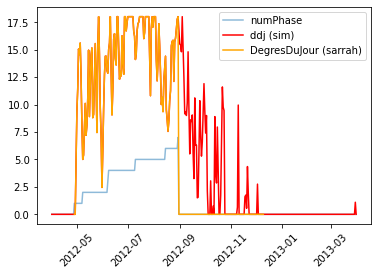

2012-08-30


/tmp/ipykernel_7757/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


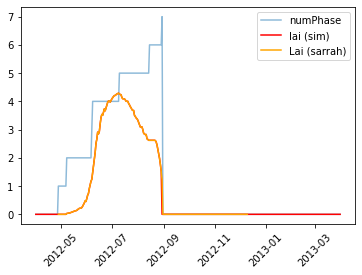

2012-08-31


/tmp/ipykernel_7757/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


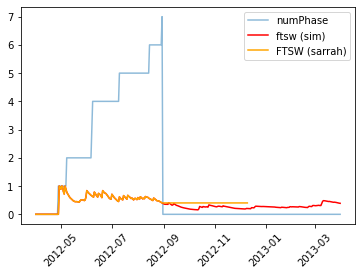

2012-08-31


/tmp/ipykernel_7757/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


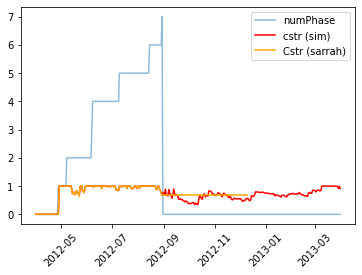

1990-01-01


/tmp/ipykernel_7757/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


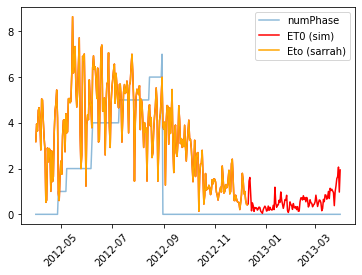

2012-08-31


/tmp/ipykernel_7757/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


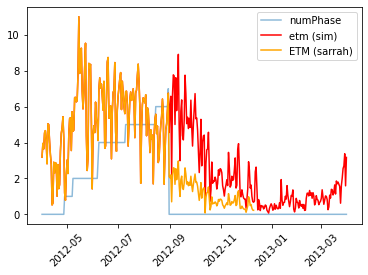

2012-08-31


/tmp/ipykernel_7757/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


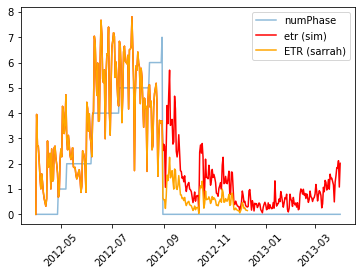

2012-08-31


/tmp/ipykernel_7757/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


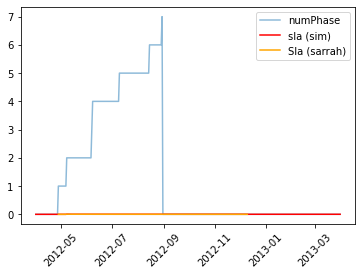

2012-08-30


/tmp/ipykernel_7757/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


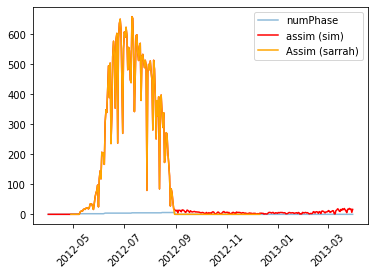

1990-01-01


/tmp/ipykernel_7757/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


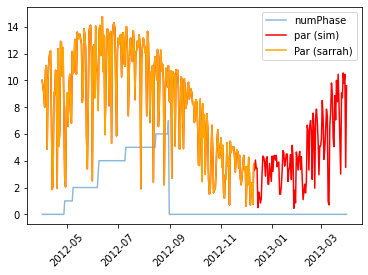

1990-01-01


/tmp/ipykernel_7757/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


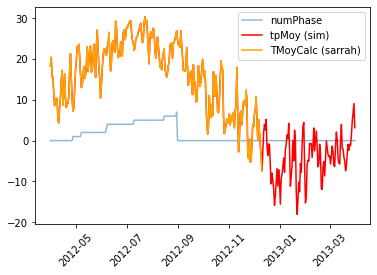

1990-01-01


/tmp/ipykernel_7757/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


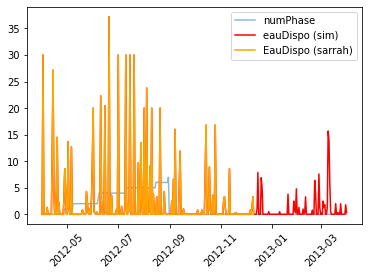

2012-08-31


/tmp/ipykernel_7757/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


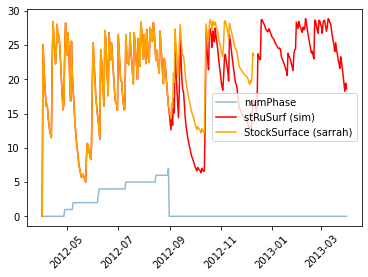

2012-08-31


/tmp/ipykernel_7757/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


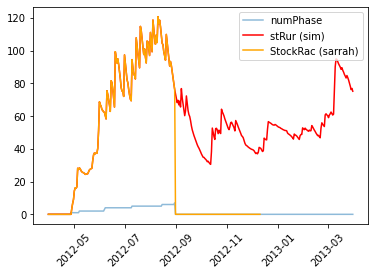

2012-08-31


/tmp/ipykernel_7757/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


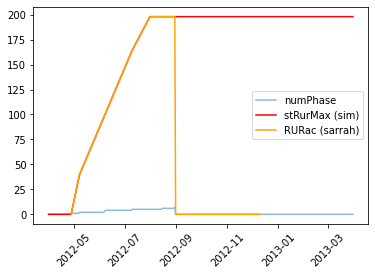

2012-08-31


/tmp/ipykernel_7757/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


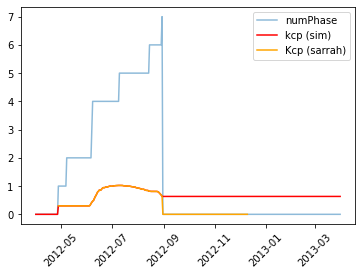

2012-09-01


/tmp/ipykernel_7757/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


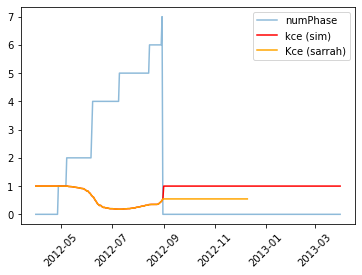

2012-09-01


/tmp/ipykernel_7757/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


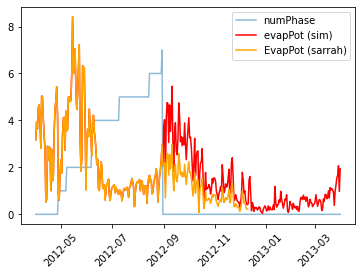

2012-09-01


/tmp/ipykernel_7757/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


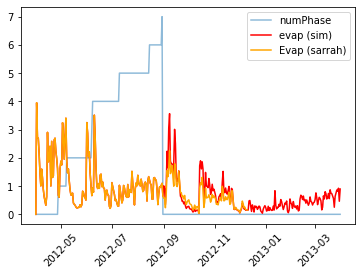

2012-08-31


/tmp/ipykernel_7757/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


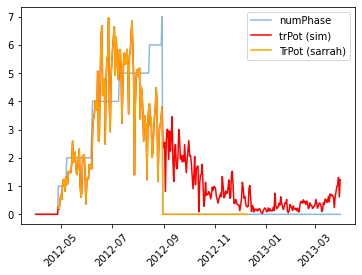

2012-08-31


/tmp/ipykernel_7757/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


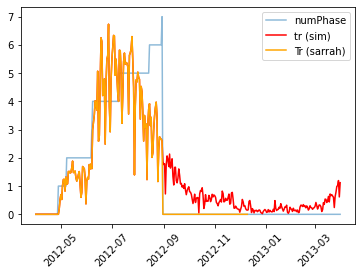

1990-01-01


/tmp/ipykernel_7757/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


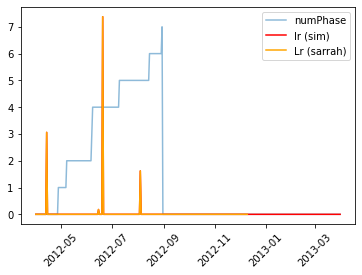

1990-01-01


/tmp/ipykernel_7757/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


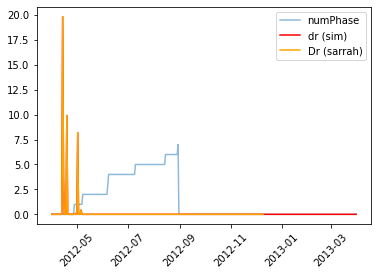

2012-08-31


/tmp/ipykernel_7757/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


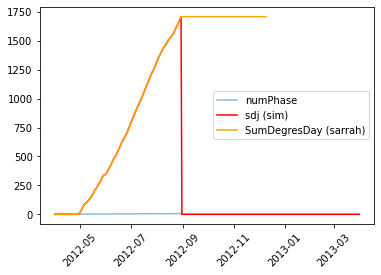

2012-08-30


/tmp/ipykernel_7757/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


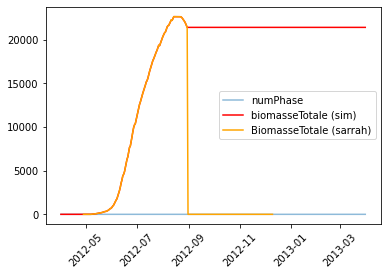

2012-08-30


/tmp/ipykernel_7757/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


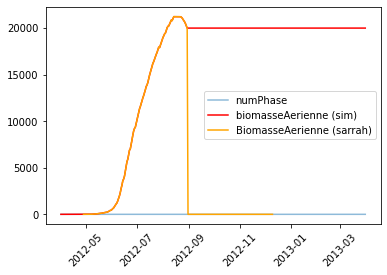

2012-08-30


/tmp/ipykernel_7757/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


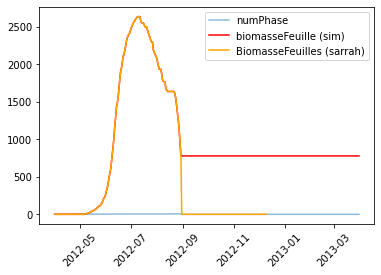

2012-08-30


/tmp/ipykernel_7757/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


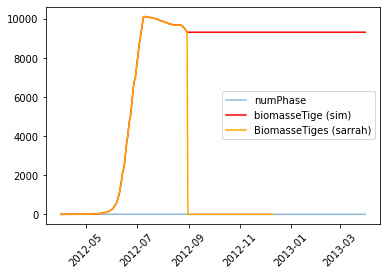

2012-08-30


/tmp/ipykernel_7757/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


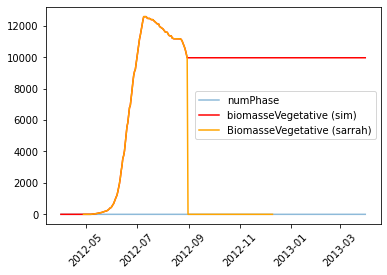

2012-08-31


/tmp/ipykernel_7757/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


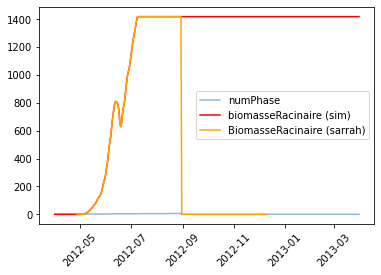

2012-08-31


/tmp/ipykernel_7757/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


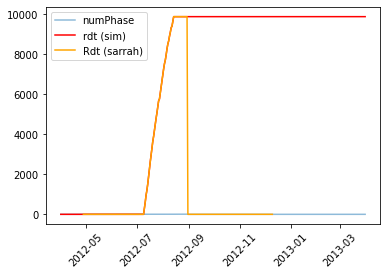

1990-01-01


/tmp/ipykernel_7757/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


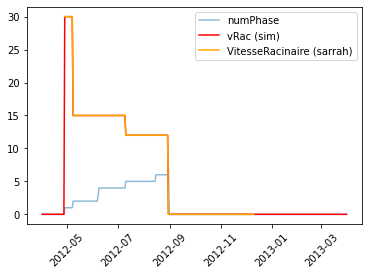

2012-09-01


/tmp/ipykernel_7757/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


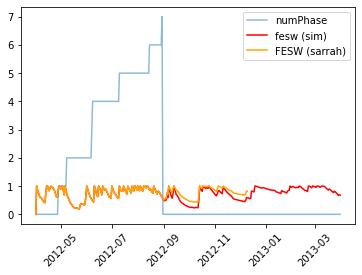

2012-08-31


/tmp/ipykernel_7757/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


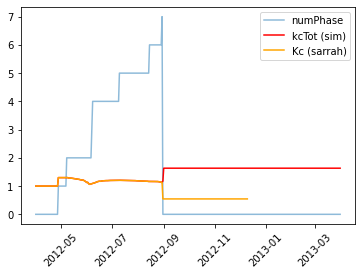

2012-08-31


/tmp/ipykernel_7757/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


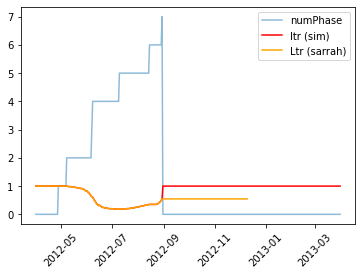

2012-08-31


/tmp/ipykernel_7757/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


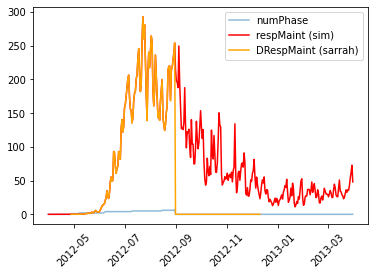

2012-08-30


/tmp/ipykernel_7757/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


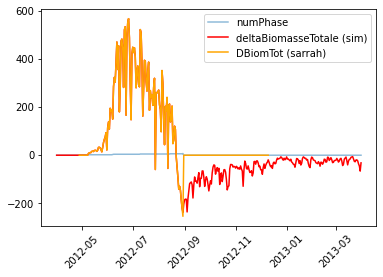

2012-08-15


/tmp/ipykernel_7757/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


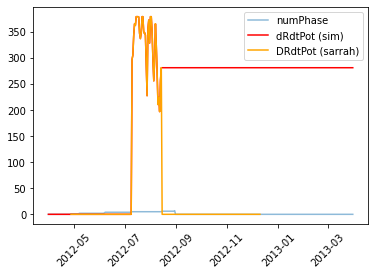

1990-01-01


/tmp/ipykernel_7757/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


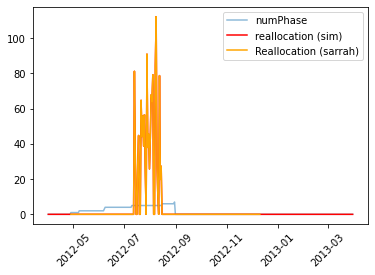

2012-08-31


/tmp/ipykernel_7757/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


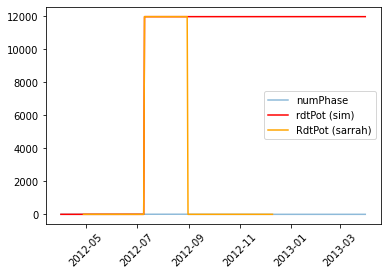

1990-01-01


/tmp/ipykernel_7757/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


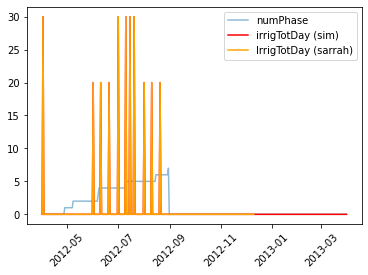

2012-08-30


/tmp/ipykernel_7757/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


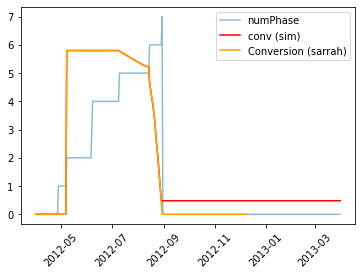

2012-08-31


/tmp/ipykernel_7757/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


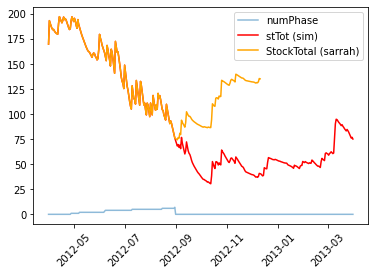

1990-01-01


/tmp/ipykernel_7757/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


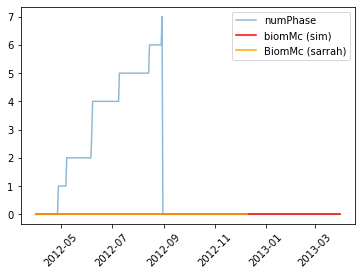

1990-01-01


/tmp/ipykernel_7757/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


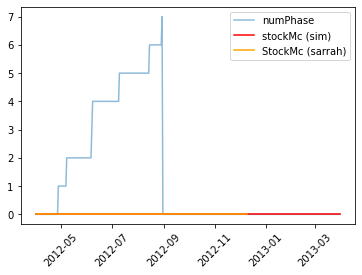

nan
nan
nan
nan
2012-09-05


/tmp/ipykernel_7757/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))
/tmp/ipykernel_7757/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))
/tmp/ipykernel_7757/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))
/tmp/ipykernel_7757/1212108693.py:9: FutureWarning: The frame.append method is deprecated and 

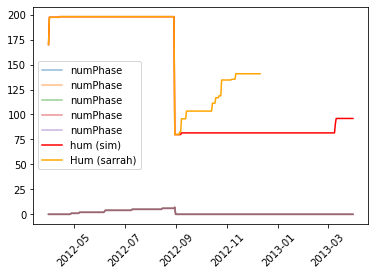

In [12]:
diff = pd.DataFrame()

for var in var_correspondance :
    try:
        # print(var,var_correspondance[var])
        
        date, meandiff = compute_earliest_diff(var, var_correspondance[var])
        print(date)
        diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))
        try:
            graph_comparison(var, var_correspondance[var])
        except:
            pass
    except:
        print(var,'failed')
        pass

In [13]:
diff.sort_values(by="earliest_diff")

,var,var2,earliest_diff,meandiff
0,Dr,dr,1990-01-01,4.482963e-16
0,StockMc,stockMc,1990-01-01,0.000000e+00
0,BiomMc,biomMc,1990-01-01,0.000000e+00
0,Lr,lr,1990-01-01,6.010066e-18
0,Eto,ET0,1990-01-01,0.000000e+00
0,VitesseRacinaire,vRac,1990-01-01,0.000000e+00
0,IrrigTotDay,irrigTotDay,1990-01-01,0.000000e+00
0,Reallocation,reallocation,1990-01-01,2.900861e-14
0,EauDispo,eauDispo,1990-01-01,1.398706e-17
0,Par,par,1990-01-01,0.000000e+00
